#  0. preprocessing

In [42]:
"""Example running MemN2N on a single bAbI task.
Download tasks from facebook.ai/babi """
from __future__ import absolute_import
from __future__ import print_function

from data_utils import load_task, vectorize_data
from sklearn import metrics
from sklearn.model_selection import train_test_split
from memn2n import MemN2N
from itertools import chain
from six.moves import range, reduce

import tensorflow as tf
import tensorboard as tb
import numpy as np

In [43]:
tf.app.flags.DEFINE_string('f', '', 'kernel')
tf.flags.DEFINE_float("learning_rate", 0.01, "Learning rate for SGD.")
tf.flags.DEFINE_float("anneal_rate", 25, "Number of epochs between halving the learnign rate.")
tf.flags.DEFINE_float("anneal_stop_epoch", 100, "Epoch number to end annealed lr schedule.")
tf.flags.DEFINE_float("max_grad_norm", 40.0, "Clip gradients to this norm.")
tf.flags.DEFINE_integer("evaluation_interval", 10, "Evaluate and print results every x epochs")
tf.flags.DEFINE_integer("batch_size", 32, "Batch size for training.")
tf.flags.DEFINE_integer("hops", 3, "Number of hops in the Memory Network.")
tf.flags.DEFINE_integer("epochs", 100, "Number of epochs to train for.")
tf.flags.DEFINE_integer("embedding_size", 20, "Embedding size for embedding matrices.")
tf.flags.DEFINE_integer("memory_size",5, "Maximum size of memory.")
tf.flags.DEFINE_integer("task_id",3, "bAbI task id, 1 <= id <= 20")
tf.flags.DEFINE_integer("random_state", None, "Random state.")
tf.flags.DEFINE_string("data_dir", "memn2n/data/tasks_1-20_v1-2/en/", "Directory containing bAbI tasks")
FLAGS = tf.flags.FLAGS

print("Started Task:", FLAGS.task_id)

DuplicateFlagError: The flag 'f' is defined twice. First from c:\program files\python36\lib\site-packages\ipykernel_launcher.py, Second from c:\program files\python36\lib\site-packages\ipykernel_launcher.py.  Description from first occurrence: kernel

In [44]:
train, test = load_task(FLAGS.data_dir, FLAGS.task_id)
data = train + test
temp = data

c:\program files\python36\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [45]:
sentence_size = max(map(len, chain.from_iterable(s for s, _, _ in data)))
max_story_size = max(map(len, (s for s, _, _ in data)))


In [46]:
for s, q, a in data:
    ss =[]
    for i, sentence in enumerate(s,1):
        ls = max(0, sentence_size - len(sentence))
        

In [48]:
# task data
train, test = load_task(FLAGS.data_dir, FLAGS.task_id)
data = train + test
#데이터로부터 사용된 모든 단어를 뽑아내 어순대로 정렬한다.
vocab = sorted(reduce(lambda x, y: x | y, (set(list(chain.from_iterable(s)) + q + a) for s, q, a in data)))
#데이터로부터 뽑아낸 단어에 인덱스를 매긴다.
word_idx = dict((c, i + 1) for i, c in enumerate(vocab))

#story의 최대 길이는 10개
max_story_size = max(map(len, (s for s, _, _ in data)))
#story의 평균 사이즈는 6개
mean_story_size = int(np.mean([ len(s) for s, _, _ in data ]))
#story의 문장 길이는 6개
sentence_size = max(map(len, chain.from_iterable(s for s, _, _ in data)))
#question의 문장 길이는 3개
query_size = max(map(len, (q for _, q, _ in data)))
#메모리의 크기는 story의 크기와 50 중에 작은 걸로 정해짐
#songhune edited: 메모리 자체의 크기를 작게 만듦
memory_size = min(FLAGS.memory_size, max_story_size)
print('Memory size')
# Add time words/indexes
for i in range(memory_size):
    word_idx['time{}'.format(i+1)] = 'time{}'.format(i+1)

vocab_size = len(word_idx) + 1 # +1 for nil word
sentence_size = max(query_size, sentence_size) # for the position
#sentence 길이에 time word라는 걸 하나 붙이므로(왜 하나 붙이나? 해결됨, timeword라고 표현할 수 있는 부분은 index 하나만 붙이면 되니까)
sentence_size += 1  # +1 for time words
print("Longest sentence length", sentence_size)
print("Longest story length", max_story_size)
print("Average story length", mean_story_size)

# train/validation/test sets
S, Q, A = vectorize_data(train, word_idx, sentence_size, memory_size)
#songhune edited 맥스 스토리 사이즈를 넣는다
#trainS, valS, trainQ, valQ, trainA, valA = cross_validation.train_test_split(S, Q, A, test_size=.1, random_state=FLAGS.random_state) #this model has been depricated


c:\program files\python36\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


Memory size
Longest sentence length 8
Longest story length 228
Average story length 50


# 1. make word2vec(idx2vec)

In [49]:
trial = S.astype(str)
trial2 = Q.astype(str)

In [50]:
def extract_idx():
    a =[]
    for i in range(len(trial)):
        for j in range(len(trial[i])):
            a.append(trial[i][j].tolist())
        a.append(trial2[i].tolist())
    return a

In [51]:
trial = extract_idx()

In [52]:
trial

[['6', '33', '28', '26', '11', '0', '0', '39'],
 ['25', '33', '2', '28', '26', '14', '0', '38'],
 ['6', '16', '28', '26', '22', '0', '0', '37'],
 ['19', '9', '26', '10', '0', '0', '0', '36'],
 ['15', '21', '28', '26', '4', '0', '0', '35'],
 ['34', '32', '26', '10', '5', '26', '3', '0'],
 ['6', '16', '28', '26', '22', '0', '0', '39'],
 ['19', '9', '26', '10', '0', '0', '0', '38'],
 ['15', '21', '28', '26', '4', '0', '0', '37'],
 ['15', '30', '28', '26', '22', '0', '0', '36'],
 ['15', '30', '28', '26', '4', '0', '0', '35'],
 ['34', '32', '26', '10', '5', '26', '3', '0'],
 ['15', '21', '28', '26', '4', '0', '0', '39'],
 ['15', '30', '28', '26', '22', '0', '0', '38'],
 ['15', '30', '28', '26', '4', '0', '0', '37'],
 ['6', '18', '26', '1', '0', '0', '0', '36'],
 ['25', '30', '28', '26', '17', '0', '0', '35'],
 ['34', '32', '26', '1', '5', '26', '11', '0'],
 ['15', '30', '28', '26', '4', '0', '0', '39'],
 ['6', '18', '26', '1', '0', '0', '0', '38'],
 ['25', '30', '28', '26', '17', '0', '0', 

In [53]:
import gensim

In [54]:
#making word2vec models, note for hyperparameters, sg means 'skip gram', if 0, CBOW models
model = gensim.models.Word2Vec(trial, min_count=1, window=5, size = 300, sg=1,sorted_vocab=1)

In [55]:
model.save('model_task3_300.bin')

# 2. reshaping & storing

In [56]:
len(model.wv.index2word)

40

In [57]:
sets=np.array((model.wv.index2word[0]),dtype=str)
sets

array('0', dtype='<U1')

In [58]:
sets=np.array((model.wv.index2word[0]),dtype=str)
for i in range(len(model.wv.index2word)-1):
    sets = np.append(sets,model.wv.index2word[i+1])
sets = np.hsplit(sets,40)
sets = np.array(sets)

In [59]:
sets_v = np.array(model.wv.vectors[0],dtype=str)
for i in range(len(model.wv.vectors)-1):
    sets_v = np.append(sets_v,model.wv.vectors[i+1])
sets_v=np.hsplit(sets_v,300)
sets_v=np.array(sets_v)

In [60]:
sets_v=np.transpose(sets_v)
sets_v=sets_v.astype('float')

In [61]:
total = sets,sets_v
#total=np.asarray(c)

In [62]:
for i in range(len(total[1][0].tolist())):
    total[1][0].tolist()[i]=float(total[1][0].tolist()[i])
total[1][0][i]=float(total[1][0][i])
total[1][0][i]

0.0021572565

In [63]:
dict_total = {float(total[0][0].tolist()[0]):total[1][0].tolist()}

for i in range(len(total[0])):
    dict_total[float(total[0][i].tolist()[0])]=total[1][i].tolist()

# lookup table

In [64]:
SS=S

In [65]:
SS=SS.tolist()

In [66]:
SS[0]

[[6, 33, 28, 26, 11, 0, 0, 39],
 [25, 33, 2, 28, 26, 14, 0, 38],
 [6, 16, 28, 26, 22, 0, 0, 37],
 [19, 9, 26, 10, 0, 0, 0, 36],
 [15, 21, 28, 26, 4, 0, 0, 35]]

In [67]:
for i in range(len(SS)):
    for j in range(len(SS[i])):
        for k in range(len(SS[i][j])):
            if(SS[i][j][k] in dict_total):
                SS[i][j][k]=dict_total[SS[i][j][k]]

In [68]:
SS=np.array(SS)

In [69]:
np.save('SS.npy',SS)
S.shape
SS.shape

(1000, 5, 8, 300)

### 왜 사이즈 80보다 작게 해야 하는가

전체 단어의 개수 8X... 
(ex 구글 뉴스에서는 60만이다. 0/1 임베딩이라면 60만이어야 하는데.)
(성능이 좋게 나와서 300....) 근거는 크게 없다...

단어들끼리 많은 뜻을 포함하지 않음.(babi에서)
사람이 이야기하는것도 추상화할수록 
(고양이/개)
(한승현/김일택)....
임베딩//추상화... 

# T-SNE로 표현한 대략적인 인접도(Supporting Sentence ONLY)

In [164]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=4, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(8, 8)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


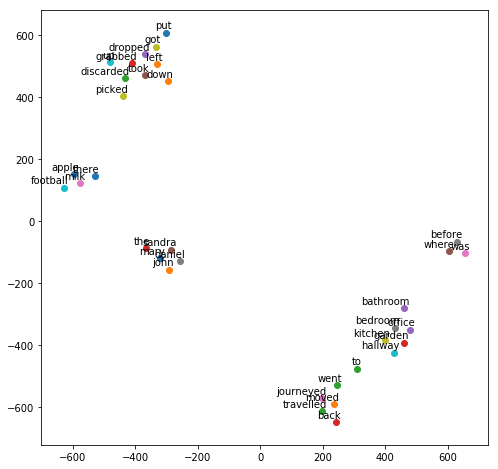

In [165]:
tsne_plot(model)

# 여기까지 했는데요, 